# Yelp Review Classifier - NLP (Customer Satisfaction)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Dataset

In [2]:
# Read .csv file
yelp_df = pd.read_csv('yelp_dataset.csv')
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Data Visualization

In [3]:
# Get Data summary description
yelp_df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


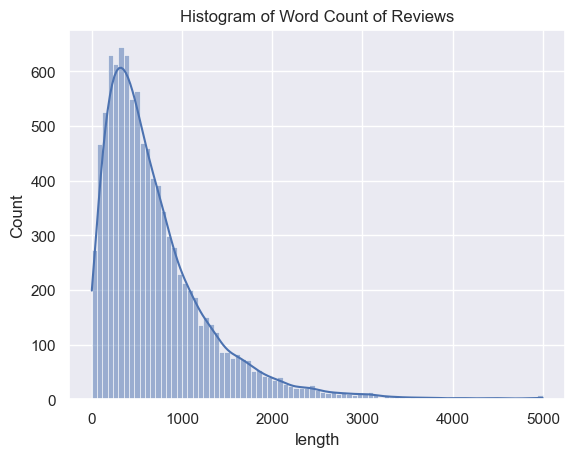

Length of Review Descripton:
 count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: length, dtype: float64


In [4]:
# Length of Reviews (Number of words)
yelp_df['length'] = yelp_df['text'].apply(len)

plt.figure()
sns.histplot(x='length', data=yelp_df, kde=True)
plt.title('Histogram of Word Count of Reviews')
plt.show()

print('Length of Review Descripton:\n',yelp_df.length.describe())

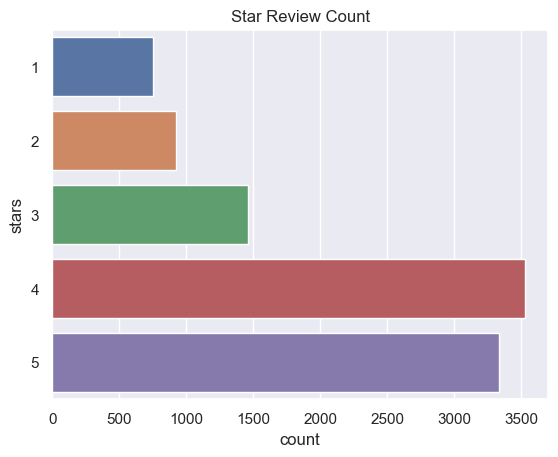

In [5]:
# Visualize Star Review Count
sns.countplot(y='stars', data=yelp_df)
plt.title('Star Review Count')
plt.show()

<Figure size 640x480 with 0 Axes>

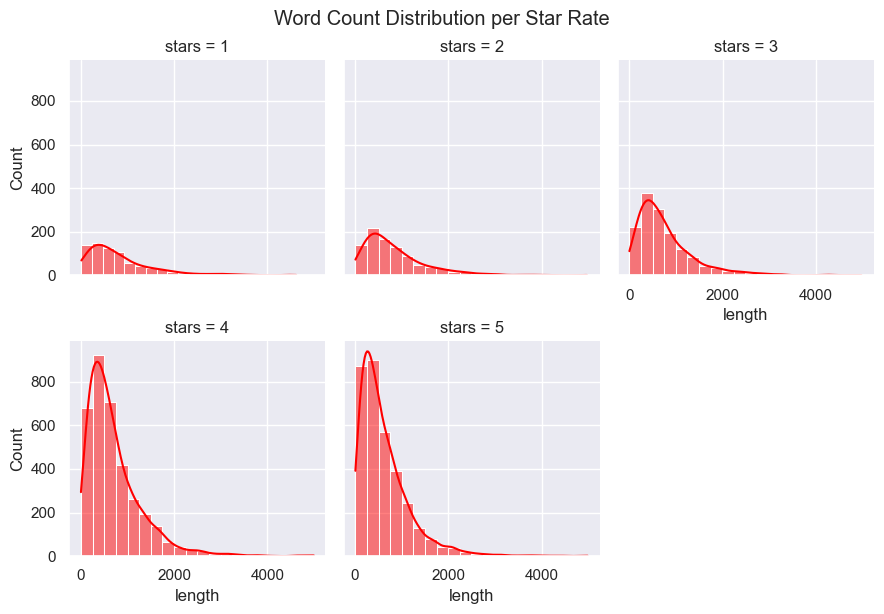

In [6]:
# Visualize the Distribution of word count based on the number of stars
plt.figure()
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(data=yelp_df, col='stars', col_wrap=3)
g.map_dataframe(sns.histplot, x='length', bins=20,
                data=yelp_df,color='red', kde=True)
g.fig.suptitle('Word Count Distribution per Star Rate',y=1.02)
plt.show()

In [7]:
# Get New Dataframe with 1 and 5 stars (Extremes)
yelp_df_1star = yelp_df[yelp_df['stars']==1]
yelp_df_5star = yelp_df[yelp_df['stars']==5]
yelp_df_1_5_star = pd.concat([yelp_df_1star, yelp_df_5star])

## Clean Data

In [8]:
print(f"Punctuation to Remove:\n{string.punctuation}\n\n")
print(f"Stopwords to Remove (Sample):\n{stopwords.words('english')[:5]}")

Punctuation to Remove:
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Stopwords to Remove (Sample):
['i', 'me', 'my', 'myself', 'we']


In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def clean_review(review):
    # Remove Punctuation
    review_punctutation_removed = [char for char in review if char not in string.punctuation]
    # Turn works to sentence
    review_punctutation_removed = ''.join(review_punctutation_removed)
    # Remove Stopwords
    review_clean = [word for word in review_punctutation_removed.split() if word.lower() not in stopwords.words('english')]
    return review_clean

In [11]:
# Demo of Cleaning Process
print("Clean Data: \n\n\n",clean_review(yelp_df['text'][0]))
print('========================================================================================')
print("Original Data: \n\n\n",yelp_df['text'][0])

Clean Data: 


 ['wife', 'took', 'birthday', 'breakfast', 'excellent', 'weather', 'perfect', 'made', 'sitting', 'outside', 'overlooking', 'grounds', 'absolute', 'pleasure', 'waitress', 'excellent', 'food', 'arrived', 'quickly', 'semibusy', 'Saturday', 'morning', 'looked', 'like', 'place', 'fills', 'pretty', 'quickly', 'earlier', 'get', 'better', 'favor', 'get', 'Bloody', 'Mary', 'phenomenal', 'simply', 'best', 'Ive', 'ever', 'Im', 'pretty', 'sure', 'use', 'ingredients', 'garden', 'blend', 'fresh', 'order', 'amazing', 'EVERYTHING', 'menu', 'looks', 'excellent', 'white', 'truffle', 'scrambled', 'eggs', 'vegetable', 'skillet', 'tasty', 'delicious', 'came', '2', 'pieces', 'griddled', 'bread', 'amazing', 'absolutely', 'made', 'meal', 'complete', 'best', 'toast', 'Ive', 'ever', 'Anyway', 'cant', 'wait', 'go', 'back']
Original Data: 


 My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absol

## Count Vectorizer on Data

In [12]:
# Instantiate Vectorizer (with clean data analyzer)
vectorizer = CountVectorizer(analyzer=clean_review)

# Analyze data for 1 and 5 Star Only
yelp_count_vectorized = vectorizer.fit_transform(yelp_df_1_5_star['text'])

## Train Model (Naive Bays)

In [13]:
# Get Training Data (Count Vectorized) and Real Labels
X = yelp_count_vectorized
Y = yelp_df_1_5_star['stars'].values

# Divide Data into Training and Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Naive Bayes Classifier Instance
NB_classifier = MultinomialNB()

# Fit Classifier
NB_classifier.fit(X=X_train, y=Y_train)


MultinomialNB()

## Evaluate Model

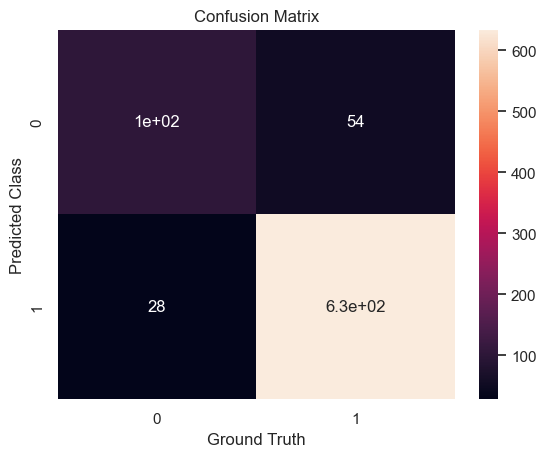

In [14]:
# Get Prediction for Y_Test
y_predict_test = NB_classifier.predict(X=X_test)
cm_test = confusion_matrix(y_true=Y_test, y_pred=y_predict_test)

plt.figure()
sns.heatmap(cm_test, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Class')
plt.show()

In [15]:
# Show Classification Report
print(classification_report(y_true=Y_test, y_pred=y_predict_test))

              precision    recall  f1-score   support

           1       0.78      0.65      0.71       156
           5       0.92      0.96      0.94       662

    accuracy                           0.90       818
   macro avg       0.85      0.81      0.83       818
weighted avg       0.90      0.90      0.90       818



## Manual Typed Test

In [16]:
# Manual Sample 
print("Manual Sample (Not Test Set) \n\n")
test_sample = ['Amazing food! Hight recommended',
               'Shit food, made me sick',
               "The best place I've been in my life"]
# Count Vectorize the manual sample
testing_sample_vectorized_data = vectorizer.transform(test_sample)

# Predict using NB Classifier
test_prediction = NB_classifier.predict(testing_sample_vectorized_data)
# Results
print("Test 1: ",test_sample[0],'\nTest 2: ',test_sample[1],'\nTest 3: ',test_sample[2])
print('=======================================================================')
print(f"\nTest 1: {test_prediction[0]} Star\nTest 2: {test_prediction[1]} Star\nTest 3: {test_prediction[2]} Star")


Manual Sample (Not Test Set) 


Test 1:  Amazing food! Hight recommended 
Test 2:  Shit food, made me sick 
Test 3:  The best place I've been in my life

Test 1: 5 Star
Test 2: 1 Star
Test 3: 5 Star


## Repeating with TF-IDF (Term Frequency - Inverse Document Frequency)

In [17]:
# If a word appears several times in a document, it might be meaningful
# If we word also appears in several documents, it could be a non-important word

# Create and Fit TFIDF object with Count Vectorized Data
# This gives a score to the words based on frequency
yelp_tfidf = TfidfTransformer().fit_transform(yelp_count_vectorized)

# Get Training Data (Count Vectorized) and Real Labels
X_tfidf = yelp_count_vectorized
Y_tfidf = yelp_df_1_5_star['stars'].values

# Divide Data into Training and Test
X_train_tfidf, X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(X_tfidf, Y_tfidf, test_size=0.2)

# Naive Bayes Classifier Instance
NB_classifier_tfidf = MultinomialNB()

# Fit Classifier
NB_classifier_tfidf.fit(X=X_train_tfidf, y=Y_train_tfidf)

MultinomialNB()

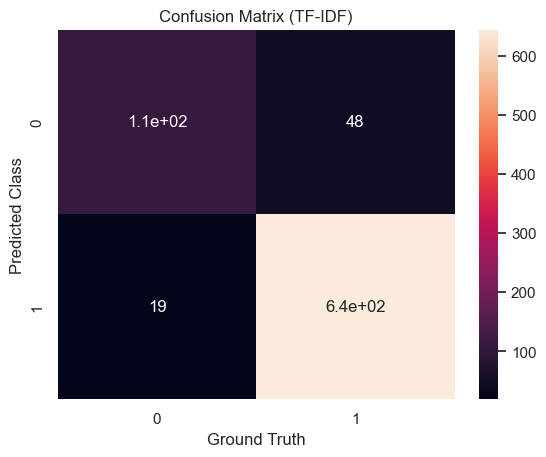

In [18]:
# Get Prediction for Y_Test
y_predict_test_tfidf = NB_classifier_tfidf.predict(X=X_test_tfidf)
cm_test_tfidf = confusion_matrix(y_true=Y_test_tfidf, y_pred=y_predict_test_tfidf)

plt.figure()
sns.heatmap(cm_test_tfidf, annot=True)
plt.title('Confusion Matrix (TF-IDF)')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Class')
plt.show()

In [19]:
# Show Classification Report
print(classification_report(y_true=Y_test_tfidf, y_pred=y_predict_test_tfidf))

              precision    recall  f1-score   support

           1       0.85      0.69      0.76       155
           5       0.93      0.97      0.95       663

    accuracy                           0.92       818
   macro avg       0.89      0.83      0.86       818
weighted avg       0.92      0.92      0.91       818

